In [ ]:
# Jason Hemedinger
# Argonne National Laboratory


In [64]:
import pyart, boto3, tempfile, os, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from botocore.handlers import disable_signing
from tint import Cell_tracks
from tint import animate as tint_animate
from tint.visualization import embed_mp4_as_gif
from glob import glob
from datetime import datetime
from pylab import *
from scipy.stats import linregress
from scipy.interpolate import InterpolatedUnivariateSpline

In [2]:
def get_current_scan(station_date, key_index):
    '''
    Function will pull the latest radar scan from any radar site using 
    Amazon S3.
    ----------
    station_date= 'year/month/day/station'
    year = YYYY e.g. 1776
    month = mm e.g. 07
    day = dd e.g. 04
    site = xxxx e.g. kdix
    '''
    bucket = 'noaa-nexrad-level2'
    s3 = boto3.resource('s3')
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    
    aws_radar = s3.Bucket(bucket)
    
    for obj in aws_radar.objects.filter(Prefix= station_date):
        '{0}:{1}'.format(aws_radar.name, obj.key)
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix= station_date)]
    keys = my_list_of_keys[key_index:]
    print(my_list_of_keys[key_index:])
    
    
    return aws_radar, keys

In [3]:
#setting the radar site and which keys to pull.
aws_radar, keys = get_current_scan('2018/06/22/KLOT', key_index=-10)

['2018/06/22/KLOT/KLOT20180622_150056_V06', '2018/06/22/KLOT/KLOT20180622_150755_V06', '2018/06/22/KLOT/KLOT20180622_151454_V06', '2018/06/22/KLOT/KLOT20180622_152152_V06', '2018/06/22/KLOT/KLOT20180622_152900_V06', '2018/06/22/KLOT/KLOT20180622_153608_V06', '2018/06/22/KLOT/KLOT20180622_154317_V06', '2018/06/22/KLOT/KLOT20180622_155025_V06', '2018/06/22/KLOT/KLOT20180622_155725_V06', '2018/06/22/KLOT/KLOT20180622_160425_V06']


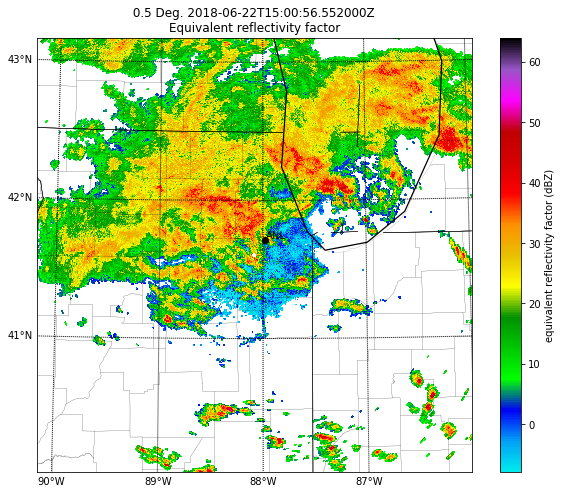

In [4]:
#animating using matplotlib and pyart
def animate(nframe):
    plt.clf()
    localfile = tempfile.NamedTemporaryFile()
    aws_radar.download_file(keys[nframe], localfile.name)
    radar = pyart.io.read(localfile.name)
    display = pyart.graph.RadarMapDisplay(radar)
    # Delete radar after use to save memory.
    del radar
    display.plot_ppi_map('reflectivity', sweep=0, resolution='l',
                         vmin=-8, vmax=64, mask_outside=False, 
                         fig=fig, width=350000, height=350000)
    display.basemap.drawcounties()
    display.plot_point(-87.981810, 41.713969 , label_text='ANL', symbol='ko')
#    display.plot_point(-87.04361, 41.46361, label_text='VU', color='k')
fig = plt.figure(figsize=(10, 8))
anim_klot = animation.FuncAnimation(fig, animate,
                                    frames=len(keys))
anim_klot.save('reflectivity_animation.gif', 
               writer='imagemagick', fps=2)
plt.show()
plt.close()

In [5]:
#turing the data into grid data and saving it to a folder
def get_grid(aws_radar, key):
    localfile = tempfile.NamedTemporaryFile()
    aws_radar.download_file(key, localfile.name)
    radar = pyart.io.read(localfile.name)
    grid = pyart.map.grid_from_radars(
            radar, grid_shape=(31, 401, 401),
            grid_limits=((0, 15000), (-200000, 200000), (-200000, 200000)),
            fields=['reflectivity'], gridding_algo='map_gates_to_grid',
            h_factor=0., nb=0.6, bsp=1., min_radius=200.)
    return grid

out_path_dir = '/home/jhemedinger/suli_projects/chicago-nowcast/events'

for num,key in enumerate(keys):
    print('saving grid', num)
    grid = get_grid(aws_radar, key)
    name = os.path.join(out_path_dir, 'grid_' + str(num).zfill(3) + '.nc')
    pyart.io.write_grid(name, grid)
    del grid

saving grid 0
saving grid 1
saving grid 2
saving grid 3
saving grid 4
saving grid 5
saving grid 6
saving grid 7
saving grid 8
saving grid 9


In [6]:
#files_2 = [os.path.join(out_dir, fn) for fn in os.listdir(out_dir)]
files = glob(out_path_dir + '/grid_*')
files.sort()

In [7]:
grid_gen = (pyart.io.read_grid(f) for f in files)
#grid_list = [pyart.io.read_grid(f) for f in files]

In [8]:
tracks_obj = Cell_tracks()
tracks_obj.get_tracks(grid_gen)

Writing tracks for scan 0
Writing tracks for scan 1
Writing tracks for scan 2
Writing tracks for scan 3
Writing tracks for scan 4
Writing tracks for scan 5
Writing tracks for scan 6
Writing tracks for scan 7
Writing tracks for scan 8
Writing tracks for scan 9


time elapsed 0.2 minutes


In [9]:
tracks_obj.tracks

time   grid_x   grid_y      lon      lat    area  \
scan uid                                                                   
0    0   2018-06-22 15:00:56  131.600    9.133 -88.8813  39.8839    15.0   
     1   2018-06-22 15:00:56  140.222   11.556 -88.7878  39.9115     9.0   
     2   2018-06-22 15:00:56  152.244   20.349 -88.6478  39.9843    86.0   
     3   2018-06-22 15:00:56  163.353   25.471 -88.5190  40.0298    17.0   
     4   2018-06-22 15:00:56  128.444   30.556 -88.9306  40.0814     9.0   
     5   2018-06-22 15:00:56  261.929   43.857 -87.3545  40.1992    14.0   
     6   2018-06-22 15:00:56  219.625   50.083 -87.8488  40.2552    24.0   
     7   2018-06-22 15:00:56  256.667   52.974 -87.4126  40.2805    39.0   
     8   2018-06-22 15:00:56  357.080   58.880 -86.2326  40.3214    25.0   
     9   2018-06-22 15:00:56  172.867   71.867 -88.4035  40.4529    15.0   
     10  2018-06-22 15:00:56  177.594   76.062 -88.3446  40.4890    32.0   
     11  2018-06-22 15:00:56  340.000   77.708 -86.4288  40.4953    24.0   
     12  2018-06-22 15:00:56  343.429   86.810 -86.3913  40.5757    21.0   
     13  2018-06-22 15:00:56  332.500   98.000 -86.5192  40.6764    16.0   
     14  2018-06-22 15:00:56  129.720  148.280 -88.9203  41.1338    25.0   
     15  2018-06-22 15:00:56  395.375  151.812 -85.7553  41.1492    16.0   
     16  2018-06-22 15:00:56  198.900  171.100 -88.0964  41.3436    10.0   
     17  2018-06-22 15:00:56  171.000  183.053 -88.4324  41.4510    38.0   
     18  2018-06-22 15:00:56  237.960  180.880 -87.6286  41.4327    25.0   
     19  2018-06-22 15:00:56  152.618  186.676 -88.6487  41.4861    68.0   
     20  2018-06-22 15:00:56  134.371  187.629 -88.8769  41.4938    35.0   
     21  2018-06-22 15:00:56  138.818  189.727 -88.8171  41.5122    11.0   
     22  2018-06-22 15:00:56  182.333  190.708 -88.3007  41.5233    24.0   
     23  2018-06-22 15:00:56  192.963  195.407 -88.1686  41.5594    27.0   
     24  2018-06-22 15:00:56  200.500  196.500 -88.0844  41.5685     8.0   
     25  2018-06-22 15:00:56   70.344  203.641 -89.6487  41.6298    64.0   
     26  2018-06-22 15:00:56  365.259  202.333 -86.0998  41.6054    27.0   
     27  2018-06-22 15:00:56  159.500  206.962 -88.5660  41.6664    26.0   
     28  2018-06-22 15:00:56  133.786  205.143 -88.8788  41.6467    14.0   
     29  2018-06-22 15:00:56  176.165  236.952 -88.3746  41.9368  1766.0   
...                      ...      ...      ...      ...      ...     ...   
9    257 2018-06-22 16:04:25  151.160  262.800 -88.6790  42.1695    25.0   
     258 2018-06-22 16:04:25  287.125  263.125 -87.0288  42.1662     8.0   
     98  2018-06-22 16:04:25  294.074  267.630 -86.9431  42.2104    27.0   
     259 2018-06-22 16:04:25  325.115  266.154 -86.5672  42.1881    26.0   
     209 2018-06-22 16:04:25  110.941  269.000 -89.1652  42.2199    17.0   
     101 2018-06-22 16:04:25  285.214  277.571 -87.0509  42.3013    14.0   
     234 2018-06-22 16:04:25  178.389  286.444 -88.3523  42.3776    18.0   
     216 2018-06-22 16:04:25  182.750  292.000 -88.2916  42.4316    12.0   
     278 2018-06-22 16:04:25  241.700  291.200 -87.5728  42.4217    10.0   
     176 2018-06-22 16:04:25  195.750  298.000 -88.1332  42.4858     8.0   
     279 2018-06-22 16:04:25  182.364  302.545 -88.3041  42.5305    11.0   
     236 2018-06-22 16:04:25  367.244  310.311 -86.0448  42.5758    45.0   
     56  2018-06-22 16:04:25  318.864  322.045 -86.6284  42.6925    88.0   
     280 2018-06-22 16:04:25  200.273  319.545 -88.0844  42.6836    11.0   
     281 2018-06-22 16:04:25  230.125  322.625 -87.7173  42.7100     8.0   
     218 2018-06-22 16:04:25  207.091  327.636 -87.9987  42.7555    22.0   
     179 2018-06-22 16:04:25  243.373  328.254 -87.5578  42.7544    67.0   
     237 2018-06-22 16:04:25  218.091  330.000 -87.8639  42.7734    11.0   
     194 2018-06-22 16:04:25  320.769  333.923 -86.6014  42.8001   104.0   
     262 2018-06-22 16:04:25  335.182  333.909 -86.4298  42.7978    11.0

In [10]:
if os.path.exists(out_path_dir + '/test_animation.mp4'):
    print(out_path_dir + '/test_animation.mp4'
          + ' already exists, removing file')
    os.remove(out_path_dir + '/test_animation.mp4')

/home/jhemedinger/suli_projects/chicago-nowcast/events/test_animation.mp4 already exists, removing file


In [11]:
grid_gen = (pyart.io.read_grid(f) for f in files)
tint_animate(tracks_obj, grid_gen, os.path.join(out_path_dir, 'test_animation'))

foobar
Animating 10 frames
Frame: 0
reflectivity 3
-8 64
Frame: 1
reflectivity 3
-8 64
Frame: 2
reflectivity 3
-8 64
Frame: 3
reflectivity 3
-8 64
Frame: 4
reflectivity 3
-8 64
Frame: 5
reflectivity 3
-8 64
Frame: 6
reflectivity 3
-8 64
Frame: 7
reflectivity 3
-8 64
Frame: 8
reflectivity 3
-8 64
Frame: 9
reflectivity 3
-8 64


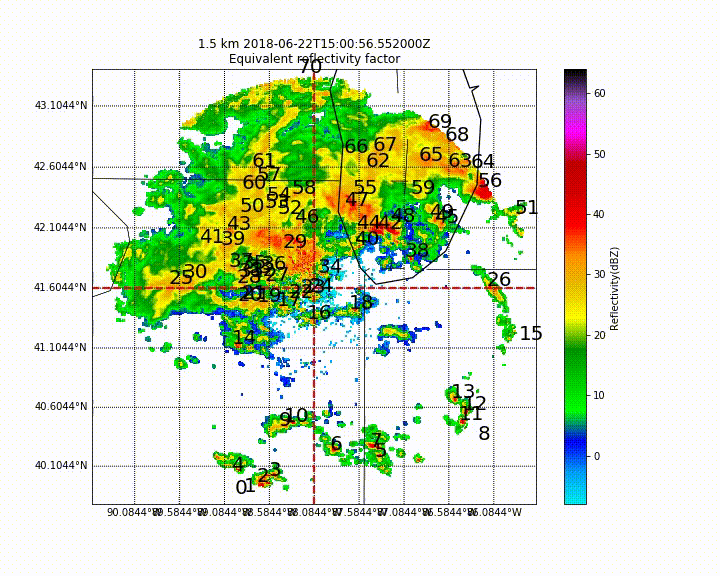

In [12]:
embed_mp4_as_gif(out_path_dir + '/test_animation.mp4')

In [13]:
df = pd.DataFrame(tracks_obj.tracks)
idx = pd.IndexSlice

arr = np.arange(0,286,1)

for i in arr:
    df_row = df.loc[idx[:, str(i)],:]
    df_row['time'] = pd.to_datetime(df_row['time'])
    print(df_row)
    del df_row

/home/jhemedinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


                        time   grid_x  grid_y      lon      lat  area   vol  \
scan uid                                                                      
0    0   2018-06-22 15:00:56  131.600   9.133 -88.8813  39.8839  15.0  16.0   
1    0   2018-06-22 15:07:55  139.000  11.385 -88.7995  39.9025  13.0  22.0   
2    0   2018-06-22 15:14:54  138.042  11.042 -88.8112  39.9024  24.0  55.5   
3    0   2018-06-22 15:21:52  136.500  10.458 -88.8345  39.8933  24.0  76.5   
4    0   2018-06-22 15:29:00  136.240   9.880 -88.8345  39.8933  25.0  75.0   

                max  max_alt  isolated  
scan uid                                
0    0    36.045952      4.0     False  
1    0    37.814869      4.5     False  
2    0    43.963120      5.5     False  
3    0    45.513451      7.0     False  
4    0    46.668743      7.0     False  
                        time   grid_x  grid_y      lon      lat  area   vol  \
scan uid                                                                      
0

                        time  grid_x   grid_y      lon      lat  area   vol  \
scan uid                                                                      
0    17  2018-06-22 15:00:56  171.00  183.053 -88.4324  41.4510  38.0  31.5   
1    17  2018-06-22 15:07:55  179.60  190.800 -88.3247  41.5233  20.0  17.5   
2    17  2018-06-22 15:14:54  176.25  191.375 -88.3727  41.5231   8.0   6.0   

                max  max_alt  isolated  
scan uid                                
0    17   47.733952      4.0     False  
1    17   41.000000      3.5     False  
2    17   35.383560      3.5     False  
                        time  grid_x  grid_y      lon      lat  area   vol  \
scan uid                                                                     
0    18  2018-06-22 15:00:56  237.96  180.88 -87.6286  41.4327  25.0  46.5   

                max  max_alt  isolated  
scan uid                                
0    18   44.015224      4.0     False  
                        time   grid_x   g

0    30   34.12001      4.5     False  
                        time   grid_x   grid_y      lon      lat  area   vol  \
scan uid                                                                       
0    31  2018-06-22 15:00:56  135.417  210.667 -88.8674  41.7007  12.0  28.0   

                max  max_alt  isolated  
scan uid                                
0    31   37.002739      4.0     False  
                        time   grid_x   grid_y      lon      lat  area   vol  \
scan uid                                                                       
0    32  2018-06-22 15:00:56  146.647  211.412 -88.7228  41.7016  17.0  23.5   

                max  max_alt  isolated  
scan uid                                
0    32   39.205837      3.5     False  
                        time  grid_x  grid_y      lon      lat  area  vol  \
scan uid                                                                    
0    33  2018-06-22 15:00:56   143.0  213.75 -88.7713  41.7283   8.0  4.0   



                        time   grid_x   grid_y      lon      lat  area   vol  \
scan uid                                                                       
0    51  2018-06-22 15:00:56  391.097  268.516 -85.7654  42.2018  31.0  39.5   

                max  max_alt  isolated  
scan uid                                
0    51   34.689861      4.0     False  
                        time  grid_x   grid_y      lon      lat  area  vol  \
scan uid                                                                     
0    52  2018-06-22 15:00:56   172.0  268.941 -88.4245  42.2245  17.0  9.5   

                max  max_alt  isolated  
scan uid                                
0    52   35.506809      3.5     False  
                        time  grid_x  grid_y      lon      lat  area   vol  \
scan uid                                                                     
0    53  2018-06-22 15:00:56   159.4   273.8 -88.5827  42.2689  40.0  31.0   

                max  max_alt  isolated  
sc

0    70   35.169411      4.5     False  
                        time   grid_x  grid_y      lon      lat  area   vol  \
scan uid                                                                      
1    71  2018-06-22 15:07:55  126.857  29.929 -88.9423  40.0724  14.0  31.0   

                max  max_alt  isolated  
scan uid                                
1    71   46.881828      5.0     False  
                        time   grid_x  grid_y      lon      lat  area   vol  \
scan uid                                                                      
1    72  2018-06-22 15:07:55  114.167  41.250 -89.0965  40.1700  12.0  33.5   
2    72  2018-06-22 15:14:54  112.375  40.688 -89.1200  40.1698  16.0  36.5   
3    72  2018-06-22 15:21:52  112.130  40.304 -89.1199  40.1608  23.0  51.0   
4    72  2018-06-22 15:29:00  111.739  39.826 -89.1199  40.1608  23.0  63.0   
5    72  2018-06-22 15:36:08  111.500  39.200 -89.1198  40.1518  20.0  44.5   

                max  max_alt  isolated  
sca

                        time   grid_x   grid_y      lon      lat  area   vol  \
scan uid                                                                       
1    84  2018-06-22 15:07:55  236.652  182.478 -87.6406  41.4417  23.0  41.0   
2    84  2018-06-22 15:14:54  235.348  183.826 -87.6644  41.4598  23.0  40.5   
3    84  2018-06-22 15:21:52  233.652  185.391 -87.6764  41.4688  23.0  31.0   
4    84  2018-06-22 15:29:00  231.400  187.667 -87.7122  41.4959  15.0  19.5   
5    84  2018-06-22 15:36:08  229.750  189.250 -87.7242  41.5050   8.0   6.0   

                max  max_alt  isolated  
scan uid                                
1    84   41.847893      3.5     False  
2    84   42.023750      3.5     False  
3    84   41.024204      3.5     False  
4    84   41.500000      3.0     False  
5    84   35.653141      1.5     False  
                        time   grid_x   grid_y      lon      lat  area   vol  \
scan uid                                                                

                        time   grid_x   grid_y      lon      lat  area   vol  \
scan uid                                                                       
1    97  2018-06-22 15:07:55  121.062  254.062 -89.0418  42.0861  16.0  24.5   

                max  max_alt  isolated  
scan uid                                
1    97   34.830421      3.5     False  
                        time   grid_x   grid_y      lon      lat  area    vol  \
scan uid                                                                        
1    98  2018-06-22 15:07:55  314.417  261.458 -86.7017  42.1448  24.0   48.0   
2    98  2018-06-22 15:14:54  311.500  262.263 -86.7257  42.1541  38.0   84.0   
3    98  2018-06-22 15:21:52  308.792  260.458 -86.7625  42.1365  48.0  104.0   
4    98  2018-06-22 15:29:00  305.638  260.213 -86.7989  42.1369  47.0  122.0   
5    98  2018-06-22 15:36:08  302.125  259.594 -86.8474  42.1374  64.0  156.5   
6    98  2018-06-22 15:43:17  299.771  261.979 -86.8713  42.1557  48.

                        time   grid_x  grid_y      lon      lat  area   vol  \
scan uid                                                                      
2    115 2018-06-22 15:14:54  300.000  44.500 -86.9072  40.1954  12.0  24.5   
3    115 2018-06-22 15:21:52  298.333  46.917 -86.9302  40.2226  12.0  20.5   
4    115 2018-06-22 15:29:00  296.800  49.200 -86.9417  40.2407  10.0  13.5   
5    115 2018-06-22 15:36:08  302.471  52.294 -86.8823  40.2671  17.0  36.5   
6    115 2018-06-22 15:43:17  301.800  54.840 -86.8819  40.2941  25.0  58.5   
7    115 2018-06-22 15:50:25  301.738  56.833 -86.8815  40.3121  42.0  88.5   
8    115 2018-06-22 15:57:25  298.833  59.083 -86.9166  40.3304  12.0  18.5   

                max  max_alt  isolated  
scan uid                                
2    115  43.875778      4.5     False  
3    115  38.492260      4.0      True  
4    115  37.613327      4.0     False  
5    115  43.136433      4.5      True  
6    115  46.000000      5.0     False  
7

                        time   grid_x  grid_y      lon      lat  area  vol  \
scan uid                                                                     
2    126 2018-06-22 15:14:54  121.875   246.0 -89.0286  42.0143   8.0  5.0   

                max  max_alt  isolated  
scan uid                                
2    126  34.773281      4.5     False  
                        time  grid_x   grid_y      lon      lat  area   vol  \
scan uid                                                                      
2    127 2018-06-22 15:14:54   263.0  245.778 -87.3219  42.0156   9.0  16.0   

                max  max_alt  isolated  
scan uid                                
2    127  36.456303      4.0     False  
                        time   grid_x   grid_y      lon      lat  area  vol  \
scan uid                                                                      
2    128 2018-06-22 15:14:54  193.375  246.875 -88.1692  42.0271   8.0  5.5   

               max  max_alt  isolated  
sca

                        time   grid_x   grid_y     lon      lat  area   vol  \
scan uid                                                                      
3    147 2018-06-22 15:21:52  271.667  163.267 -87.223  41.2685  15.0  14.5   

                max  max_alt  isolated  
scan uid                                
3    147  34.227058      3.5     False  
                        time   grid_x  grid_y      lon      lat  area  vol  \
scan uid                                                                     
3    148 2018-06-22 15:21:52  222.900  188.20 -87.8083  41.4962  10.0  6.0   
4    148 2018-06-22 15:29:00  220.833  189.25 -87.8323  41.5052  12.0  6.5   

           max  max_alt  isolated  
scan uid                           
3    148  38.5      3.5     False  
4    148  42.0      3.5     False  
                        time   grid_x   grid_y      lon     lat  area   vol  \
scan uid                                                                      
3    149 2018-06-22 15:2

                        time   grid_x   grid_y      lon      lat  area  vol  \
scan uid                                                                      
4    169 2018-06-22 15:29:00  177.545  182.091 -88.3484  41.4423  11.0  7.0   

           max  max_alt  isolated  
scan uid                           
4    169  41.5      3.5     False  
                        time   grid_x   grid_y      lon      lat  area   vol  \
scan uid                                                                       
4    170 2018-06-22 15:29:00  172.231  183.846 -88.4205  41.4601  13.0  13.5   
5    170 2018-06-22 15:36:08  169.750  184.667 -88.4445  41.4690  12.0  11.0   
6    170 2018-06-22 15:43:17  167.684  185.105 -88.4685  41.4689  19.0  16.5   
7    170 2018-06-22 15:50:25  164.000  184.417 -88.5165  41.4597  12.0   9.5   
8    170 2018-06-22 15:57:25  159.692  183.538 -88.5645  41.4596  13.0  10.0   

                max  max_alt  isolated  
scan uid                                
4    170  3

                        time   grid_x   grid_y      lon      lat  area    vol  \
scan uid                                                                        
4    182 2018-06-22 15:29:00  221.111  381.611 -87.8252  43.2409  18.0   22.0   
5    182 2018-06-22 15:36:08  216.600  383.286 -87.8746  43.2500  35.0   58.5   
6    182 2018-06-22 15:43:17  211.640  384.040 -87.9363  43.2591  25.0   40.5   
7    182 2018-06-22 15:50:25  207.412  384.235 -87.9980  43.2592  51.0  102.5   
8    182 2018-06-22 15:57:25  204.391  380.870 -88.0351  43.2322  23.0   45.5   
9    182 2018-06-22 16:04:25  194.061  382.162 -88.1585  43.2412  99.0  230.5   

                max  max_alt  isolated  
scan uid                                
4    182  35.500000      3.5     False  
5    182  36.000000      4.5     False  
6    182  33.749668      4.0     False  
7    182  36.410061      4.5     False  
8    182  36.496986      4.5     False  
9    182  37.250000      4.5     False  
                       

8    198  36.017090      4.0     False  
                        time   grid_x  grid_y      lon      lat  area   vol  \
scan uid                                                                      
6    199 2018-06-22 15:43:17  121.750  41.125 -89.0024  40.1708   8.0  12.5   
7    199 2018-06-22 15:50:25  121.579  40.263 -89.0022  40.1618  19.0  32.5   

                max  max_alt  isolated  
scan uid                                
6    199  42.092010      4.0     False  
7    199  43.001064      5.0     False  
                        time   grid_x  grid_y      lon      lat  area    vol  \
scan uid                                                                       
6    200 2018-06-22 15:43:17  140.500  47.125 -88.7911  40.2263   8.0   12.5   
7    200 2018-06-22 15:50:25  139.200  46.600 -88.8029  40.2262  10.0   22.5   
8    200 2018-06-22 15:57:25  136.545  44.030 -88.8262  40.1991  33.0   77.5   
9    200 2018-06-22 16:04:25  137.841  46.585 -88.8147  40.2261  82.0  235.0  

                        time   grid_x   grid_y      lon      lat  area  vol  \
scan uid                                                                      
6    215 2018-06-22 15:43:17  199.333  285.778 -88.0966  42.3779   9.0  8.5   
7    215 2018-06-22 15:50:25  195.444  287.333 -88.1453  42.3868   9.0  7.0   

                max  max_alt  isolated  
scan uid                                
6    215  35.562103      4.0     False  
7    215  36.183735      4.0     False  
                        time   grid_x   grid_y      lon      lat  area   vol  \
scan uid                                                                       
6    216 2018-06-22 15:43:17  195.250  293.250 -88.1454  42.4408   8.0   5.5   
7    216 2018-06-22 15:50:25  190.792  290.625 -88.1941  42.4228  24.0  19.5   
8    216 2018-06-22 15:57:25  185.846  290.577 -88.2550  42.4227  26.0  21.5   
9    216 2018-06-22 16:04:25  182.750  292.000 -88.2916  42.4316  12.0   8.5   

                max  max_alt  isolated

                        time   grid_x   grid_y     lon      lat  area  vol  \
scan uid                                                                     
7    238 2018-06-22 15:50:25  241.000  332.100 -87.582  42.7905  10.0  8.0   
8    238 2018-06-22 15:57:25  236.111  335.667 -87.643  42.8267   9.0  9.5   

                max  max_alt  isolated  
scan uid                                
7    238  33.518745      4.5     False  
8    238  33.806889      4.5     False  
                        time   grid_x  grid_y      lon      lat  area  vol  \
scan uid                                                                     
7    239 2018-06-22 15:50:25  339.125  358.25 -86.3749  43.0129   8.0  8.0   

                max  max_alt  isolated  
scan uid                                
7    239  33.640938      3.5     False  
                        time   grid_x  grid_y      lon      lat  area   vol  \
scan uid                                                                      
8    24

                        time   grid_x   grid_y      lon      lat  area  vol  \
scan uid                                                                      
8    260 2018-06-22 15:57:25  374.222  283.889 -85.9672  42.3406   9.0  9.0   

                max  max_alt  isolated  
scan uid                                
8    260  33.844162      3.5     False  
                        time   grid_x   grid_y      lon      lat  area   vol  \
scan uid                                                                       
8    261 2018-06-22 15:57:25  296.633  333.267 -86.8957  42.7945  30.0  60.5   
9    261 2018-06-22 16:04:25  293.205  338.636 -86.9437  42.8489  44.0  65.0   

                max  max_alt  isolated  
scan uid                                
8    261  34.172726      3.5     False  
9    261  35.000637      4.0     False  
                        time   grid_x   grid_y      lon      lat  area   vol  \
scan uid                                                                  

In [156]:
tracks_obj.tracks.groupby(level='uid').size().sort_values(ascending=False)[:5]

uid
56    10
22    10
7     10
47    10
9     10
dtype: int64

['2018-06-22T15:14:54.000000000' '2018-06-22T15:21:52.000000000'
 '2018-06-22T15:29:00.000000000' '2018-06-22T15:36:08.000000000'
 '2018-06-22T15:43:17.000000000' '2018-06-22T15:50:25.000000000'
 '2018-06-22T15:57:25.000000000' '2018-06-22T16:04:25.000000000']


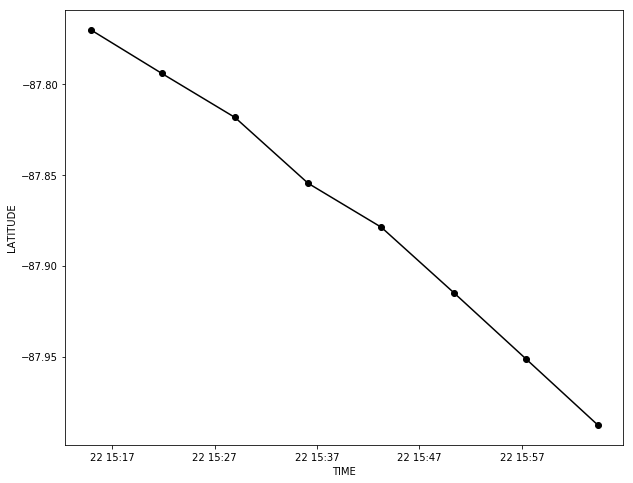

In [162]:
df_123 = pd.DataFrame(tracks_obj.tracks.xs('123', level='uid'))
#df_41 = df_41.drop('time', axis=1)
#print(df_123)
lons, lats = np.array(df_123['lon']), np.array(df_123['lat'])
#time = pd.to_numeric(df_123['time'])
#time = pd.to_datetime(time)
time = np.array(pd.to_datetime(df_123['time']))
print(time)
fig = plt.figure(figsize=(10,8))
plt.plot(time, lons, color='k', marker='o')
#plt.ylim(plt.ylim()[::-1])
plt.xlabel('TIME')
plt.ylabel('LATITUDE')
#for i, lpoint in enumerate(df_row['time']):
#plt.annotate(' {0:d} h'.format(lpoint.hour), (lons[i], lats[i]), 
#xytext=(15,0), textcoords='offset points', 
#fontsize=12, color='darkblue')
plt.show()
plt.close()

In [163]:
ts = (time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')

/home/jhemedinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  """Entry point for launching an IPython kernel.


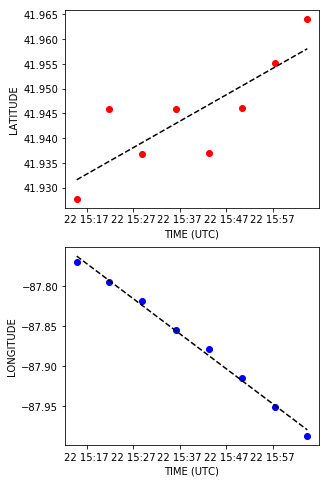

In [164]:
x = ts
y = lats
w = lons

fit_lat = polyfit(x,y,1)
fit_lon = polyfit(x,w,1)
fit_fn_lon = poly1d(fit_lon)
fit_fn_lat = poly1d(fit_lat)

fig = plt.figure(1 ,figsize=(10,8))

ax = plt.subplot(221)
plt.plot(time, y, 'ro', time, fit_fn_lat(x), '--k')
#plt.plot(lons, lats, color='y', marker='o')
#plt.plot(time, fit_fn_lat(x), '--k')
#plt.plot(time, lats, 'ro')
plt.xlabel('TIME (UTC)')
plt.ylabel('LATITUDE')

ax = plt.subplot(223)
plt.plot(time, w, 'bo', time, fit_fn_lon(x), '--k')
plt.xlabel('TIME (UTC)')
plt.ylabel('LONGITUDE')

plt.show()

In [138]:
my_new_time = time[-1] + np.timedelta64(10, 'm')

In [153]:
nts = (my_new_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
my_new_lat = fit_fn_lat(nts)
my_new_lon = fit_fn_lon(nts)

/home/jhemedinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  """Entry point for launching an IPython kernel.


In [155]:
print(my_new_lat)
print(my_new_lon)

41.9634213311
-88.0242455632
